## GAF  SignFi

In [ ]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pyts.image import GramianAngularField

# from preprocessing.csi_to_gaf import signfi_csi_to_gaf
import scipy.io as sio

In [30]:
root_dir = os.path.join('..', 'Datasets', 'SignFi')
# root_dir = '/data-2/users/coerlema/data/SignFi'

In [31]:
data_lab_276_ul = sio.loadmat(os.path.join(root_dir, 'dataset_lab_276_ul'))

gadf = GramianAngularField(method='difference')

csi = data_lab_276_ul['csiu_lab'].T
csi.shape

(5520, 3, 30, 200)

In [32]:
# csi = np.abs(csi)

In [43]:
csi_matrix = csi[0]
csi_matrix = csi_matrix.reshape((-1, csi_matrix.shape[-1]))
csi_matrix.shape

(90, 200)

In [44]:
csi_matrix = csi_matrix.T
# def signfi_csi_to_gaf(csi_matrix: np.ndarray, gadf) -> np.ndarray:
# PCA analysis https://stackoverflow.com/questions/60508233/python-implement-a-pca-using-svd
conj_multiplication_1 = csi_matrix.copy()
conj_multiplication_1 -= np.mean(conj_multiplication_1, axis=0)
U, S, Vt = np.linalg.svd(conj_multiplication_1, full_matrices=True)
V = np.transpose(Vt)

# Enforce sign convention https://nl.mathworks.com/matlabcentral/answers/300899-sign-difference-between-coeff-pca-x-and-v-svd-x
max_indices = np.argmax(np.absolute(V), axis=0)
max_value_signs = np.squeeze(np.sign(np.take_along_axis(V, np.expand_dims(max_indices, axis=0), axis=0)))
max_value_signs = np.stack([max_value_signs] * V.shape[0])
V = np.multiply(V, max_value_signs)

conj_multiplication_pca = np.matmul(csi_matrix, V[:, 0])
conj_multiplication_pca.shape

(200,)

In [45]:
conj_multiplication_pca = conj_multiplication_pca.reshape(1, -1)
conj_multiplication_pca = np.abs(conj_multiplication_pca)
conj_multiplication_pca.shape

(1, 200)

In [53]:
csi_gaf = gadf.fit_transform(conj_multiplication_pca)
print(type(csi_gaf))
csi_gaf = np.squeeze(csi_gaf)
csi_gaf.shape

<class 'numpy.ndarray'>


(200, 200)

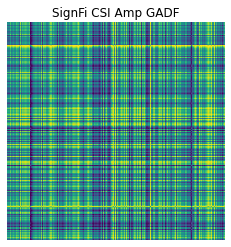

In [47]:
plt.imshow(csi_gaf.T)
plt.title('SignFi CSI Amp GADF')
plt.axis('off');

In [52]:
padded_freq_time_profile_stacked = np.stack(
    arrays=[csi_gaf, csi_gaf],
    axis=0)
padded_freq_time_profile_stacked.shape

(2, 200, 200)

## Widar gaf


In [15]:
from CSIKit.reader import IWLBeamformReader
import os
import numpy as np
from scipy import signal
from pyts.image import GramianAngularField
from matplotlib import pyplot as plt

In [16]:
a_root = os.path.join('..', 'Datasets', 'Widar')

In [17]:
def read_item(item):
    # Reading raw CSI data
    reader_obj = IWLBeamformReader()
    data_obj = reader_obj.read_file(a_root + os.sep + item)
    csi_matrix = np.stack([x.csi_matrix for x in data_obj.frames])
    return csi_matrix

In [18]:
for file in os.listdir(os.path.join(a_root, '20181112', 'user1')):
    csi = read_item(os.path.join('20181112', 'user1', file))
    print(csi.shape)

(1370, 30, 3, 1)
(1373, 30, 3, 1)
(1394, 30, 3, 1)
(1391, 30, 3, 1)
(1374, 30, 3, 1)
(1374, 30, 3, 1)
(1274, 30, 3, 1)
(1283, 30, 3, 1)
(1301, 30, 3, 1)
(1298, 30, 3, 1)
(1278, 30, 3, 1)
(1278, 30, 3, 1)


In [19]:
csi = read_item(os.path.join('20181204', 'user1', 'user1-9-5-5-5-r6.dat'))
csi.shape

(2174, 30, 3, 1)

In [20]:
csi_matrix = read_item(os.path.join('20181112', 'user1', 'user1-1-1-1-1-r1.dat'))
csi_matrix.shape

(1370, 30, 3, 1)

In [21]:
csi_matrix = np.squeeze(csi_matrix)
csi_matrix = np.transpose(csi_matrix, [2, 0, 1])
csi_matrix.shape

(3, 1370, 30)

In [22]:
## preprocessing of bram
# First, second antenna pair selection (WiDance https://dl.acm.org/doi/pdf/10.1145/3025453.3025678)
amplitude_mean = np.mean(np.absolute(csi_matrix), axis=1)
amplitude_var = np.sqrt(np.var(np.absolute(csi_matrix), axis=1))
mean_var_ratio = np.divide(amplitude_mean, amplitude_var)
mean_var_ratio = np.mean(mean_var_ratio, axis=1)
max_idx = np.argmax(mean_var_ratio)
csi_matrix_ref = np.stack([csi_matrix[max_idx]] * 3)
max_idx += 1

# Antenna power adjustment (IndoTrack https://dl.acm.org/doi/pdf/10.1145/3130940)
amplitude = np.absolute(csi_matrix)
amplitude_mask = np.ma.masked_equal(amplitude, value=0.0, copy=False)
alpha = amplitude_mask.min(axis=1)
amplitude = amplitude - np.transpose(np.stack([alpha] * amplitude.shape[1]), [1, 0, 2])
amplitude = np.absolute(amplitude)
angle = np.angle(csi_matrix)
csi_matrix = np.multiply(amplitude, np.exp(np.multiply(1j, angle)))

beta = np.divide(np.multiply(1000, np.sum(alpha)), alpha.size)
amplitude_2 = np.absolute(csi_matrix_ref)
amplitude_2 = np.add(amplitude_2, beta)
angle_2 = np.angle(csi_matrix_ref)
csi_matrix_ref = np.multiply(amplitude_2, np.exp(np.multiply(1j, angle_2)))

# Conjugate multiplication (DataPort DFSExtraction matlab script)
conj_multiplication = np.multiply(csi_matrix, np.conjugate(csi_matrix_ref))
conj_multiplication = np.transpose(conj_multiplication, [1, 0, 2])
conj_multiplication = np.reshape(conj_multiplication,
                                 newshape=(conj_multiplication.shape[0],
                                           conj_multiplication.shape[1] * conj_multiplication.shape[2])
                                 )
conj_multiplication = np.concatenate(
    (conj_multiplication[:, 0:30 * (max_idx - 1)], conj_multiplication[:, 30 * max_idx:90]), axis=-1)

# Static/high frequency component filtering (DataPort DFSExtraction matlab script)
[lb, la] = signal.butter(6, 60 / 500, 'low')
[hb, ha] = signal.butter(3, 2 / 500, 'high')
conj_multiplication = signal.lfilter(lb, la, conj_multiplication, axis=0)
conj_multiplication = signal.lfilter(hb, ha, conj_multiplication, axis=0)

# PCA analysis https://stackoverflow.com/questions/60508233/python-implement-a-pca-using-svd
# Matlab pca(X) returns principal component coefficients, also known as 'loadings' https://nl.mathworks.com/help/stats/pca.html
conj_multiplication_1 = conj_multiplication.copy()
conj_multiplication_1 -= np.mean(conj_multiplication_1, axis=0)
U, S, Vt = np.linalg.svd(conj_multiplication_1, full_matrices=True)
V = np.transpose(Vt)

# Enforce sign convention https://nl.mathworks.com/matlabcentral/answers/300899-sign-difference-between-coeff-pca-x-and-v-svd-x
max_indices = np.argmax(np.absolute(V), axis=0)
max_value_signs = np.squeeze(np.sign(np.take_along_axis(V, np.expand_dims(max_indices, axis=0), axis=0)))
max_value_signs = np.stack([max_value_signs] * V.shape[0])
V = np.multiply(V, max_value_signs)

conj_multiplication_pca = np.matmul(conj_multiplication, V[:, 0])
conj_multiplication_pca = conj_multiplication_pca.reshape(1, -1)

# convert to abs
conj_multiplication_pca = np.abs(conj_multiplication_pca)
print(conj_multiplication_pca.shape)

(1, 1370)


In [23]:
gadf = GramianAngularField(method='difference')

gaf_widar =  gadf.fit_transform(conj_multiplication_pca)
gaf_widar = np.squeeze(gaf_widar)
gaf_widar.shape

(1370, 1370)

In [24]:
gaf_widar = gaf_widar[:2000, :2000]
gaf_widar.shape

(1370, 1370)

In [25]:
gaf_widar = np.pad(gaf_widar, ((0, 2000-gaf_widar.shape[0]), (0, 2000-gaf_widar.shape[1])))
gaf_widar.shape

(2000, 2000)

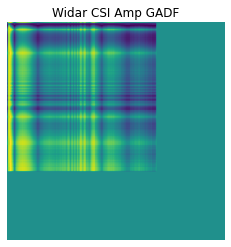

In [27]:
plt.imshow(gaf_widar)
plt.title('Widar CSI Amp GADF')
plt.axis('off');

In [30]:
gaf_widar.dtype

dtype('float64')

### Test gaf code

In [1]:
# import preprocessing.csi_to_gaf as cg
import cv2
from preprocessing.widar_csi_gaf import *
import os

In [2]:
a_root = os.path.join('..', 'Datasets', 'Widar')
user_path = os.path.join(a_root, '20181112', 'user1')

In [3]:
files = os.listdir(user_path)
first_user = files[:6]
first_user

['user1-1-1-1-1-r1.dat',
 'user1-1-1-1-1-r2.dat',
 'user1-1-1-1-1-r3.dat',
 'user1-1-1-1-1-r4.dat',
 'user1-1-1-1-1-r5.dat',
 'user1-1-1-1-1-r6.dat']

In [4]:
current_root = user_path
files_one_item = first_user
print(current_root, files_one_item)
first_item = files_one_item[0]

# process input file name to get user, room, orientation, etc..
item_name_split = first_item.split("-")
item_name_split[0] = item_name_split[0].replace("user", "")
item_name_split[-1] = item_name_split[-1].replace(".dat", "")
item_name_split[-1] = item_name_split[-1].replace("r", "")
item_name_split = list(map(int, item_name_split))

current_user = current_root.split(os.sep)[3]

if current_user == "20181109":
    room_label = 1

    item_name_split[1] = 10 if item_name_split[1] == 5 else (
        11 if item_name_split[1] == 6 else item_name_split[1]
    )
elif current_user == "20181112" or current_user == "20181116":
    room_label = 1

    item_name_split[1] += 12
elif current_user == "20181115":
    room_label = 1

    item_name_split[1] = 12 if item_name_split[1] == 4 else (
        10 if item_name_split[1] == 5 else (
            11 if item_name_split[1] == 6 else item_name_split[1]
        )
    )
elif current_user == "20181117" or current_user == "20181118":
    room_label = 2

    item_name_split[1] = 10 if item_name_split[1] == 5 else (
        11 if item_name_split[1] == 6 else (
            12 if item_name_split[1] == 4 else item_name_split[1]
        )
    )
elif current_user == "20181121" or current_user == "20181127":
    room_label = 1
    if current_user == "20181127":
        room_label = 2

    item_name_split[1] = 4 if item_name_split[1] == 1 else (
        6 if item_name_split[1] == 2 else (
            9 if item_name_split[1] == 3 else (
                5 if item_name_split[1] == 4 else (
                    8 if item_name_split[1] == 5 else (
                        7 if item_name_split[1] == 6 else item_name_split[1]
                    )
                )
            )
        )
    )
elif current_user == "20181128":
    room_label = 2

    item_name_split[1] = 6 if item_name_split[1] == 4 else (
        9 if item_name_split[1] == 5 else (
            5 if item_name_split[1] == 6 else item_name_split[1]
        )
    )
elif current_user == "20181130" or current_user == "20181204":
    room_label = 1
    if current_user == "20181204":
        room_label = 2

    item_name_split[1] = 6 if item_name_split[1] == 5 else (
        9 if item_name_split[1] == 6 else (
            5 if item_name_split[1] == 7 else (
                7 if item_name_split[1] == 9 else item_name_split[1]
            )
        )
    )
elif current_user == "20181205":
    room_label = 2
    if item_name_split[0] == 2:
        item_name_split[1] = 6 if item_name_split[1] == 1 else (
            9 if item_name_split[1] == 2 else (
                5 if item_name_split[1] == 3 else (
                    8 if item_name_split[1] == 4 else (
                        7 if item_name_split[1] == 5 else item_name_split[1]
                    )
                )
            )
        )
    elif item_name_split[0] == 3:
        item_name_split[1] = 4 if item_name_split[1] == 1 else (
            6 if item_name_split[1] == 2 else (
                9 if item_name_split[1] == 3 else (
                    5 if item_name_split[1] == 4 else (
                        8 if item_name_split[1] == 5 else (
                            7 if item_name_split[1] == 6 else item_name_split[1]
                        )
                    )
                )
            )
        )
elif current_user == "20181208":
    room_label = 2
elif current_user == "20181209":
    room_label = 2

    if item_name_split[0] == 6:
        item_name_split[1] = 6 if item_name_split[1] == 5 else (
            9 if item_name_split[1] == 6 else item_name_split[1]
        )
elif current_user == "20181211":
    room_label = 3

    item_name_split[1] = 6 if item_name_split[1] == 5 else (
        9 if item_name_split[1] == 6 else item_name_split[1]
    )
else:
    raise Exception("An unknown data collection date subfolder was encountered")

..\Datasets\Widar\20181112\user1 ['user1-1-1-1-1-r1.dat', 'user1-1-1-1-1-r2.dat', 'user1-1-1-1-1-r3.dat', 'user1-1-1-1-1-r4.dat', 'user1-1-1-1-1-r5.dat', 'user1-1-1-1-1-r6.dat']


In [5]:

# Skip specific domains/gestures for correct domain factor leave out cross-validation due to distribution imbalances
# --------------------4500 samples (6 users 5 positions 5 orientations 6 gestures 5 instances--------------------- #

# Limit number of repetitions per domain in the dataset (reduces size for hyperparameter tuning)
# if item_name_split[4] > 1:
#    return

if any(item_name_split[0] == x for x in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]):
    print('null')
if any(item_name_split[1] == x for x in [5, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]):
    print('null')
if any(item_name_split[2] == x for x in [6, 7, 8]):
    print('null')

item_name_split[0] = item_name_split[0] - 11

item_name_split[1] = 5 if item_name_split[1] == 6 else (
    6 if item_name_split[1] == 9 else item_name_split[1]
)

# One-hot vector of which every index denotes unique (user, room, position, orientation) pair
# Room label has been defined in if elif else ladder
domain_label = np.zeros((6, 1, 5, 5), dtype=np.int8)
domain_label[
    item_name_split[0] - 1,
    room_label - 1,
    item_name_split[2] - 1,
    item_name_split[3] - 1
] = 1
domain_label = domain_label.flatten()

task_label = np.zeros(6, dtype=np.int8)
task_label[item_name_split[1] - 1] = 1

null
null


IndexError: index -11 is out of bounds for axis 0 with size 6

In [7]:
gaf_one_sample = process_widar_sample_to_gaf(current_root, first_user[0])
gaf_one_sample.shape

(2000, 2000)

In [8]:
np.stack([gaf_one_sample, gaf_one_sample], axis=2).shape

(2000, 2000, 2)

In [9]:
gaf_stacked = np.stack(
    arrays=[process_widar_sample_to_gaf(current_root, x) for x in files_one_item],
    axis=2)
gaf_resized = cv2.resize(gaf_stacked, (500, 500))
# doppler_spectrum_samples = np.transpose(a=gaf_stacked, axes=(1, 2, 0)).astype(dtype=np.float32)
print(gaf_resized.shape)

(500, 500, 6)


In [17]:
gaf_resized.dtype, gaf_resized.shape, type(gaf_resized)

(dtype('float64'), (500, 500, 6), numpy.ndarray)

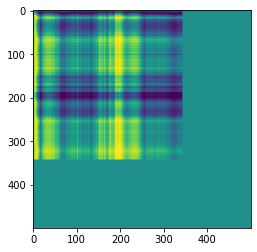

In [12]:
import matplotlib.pyplot as plt
plt.imshow(gaf_resized[:, : ,1])

In [14]:
gaf_resized_range = (gaf_resized - gaf_resized.min())/(gaf_resized.max()-gaf_resized.min())

In [15]:
gaf_resized_range.min(), gaf_resized.max()

(0.0, 0.9999942629759525)

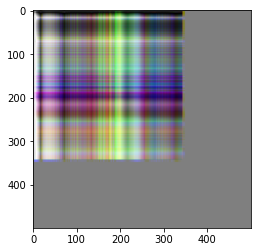

In [16]:
plt.imshow(gaf_resized_range[: ,:, :3])